# StyleGAN latent space exploration

## План занятие:
1. Подробнее разобрать StyleGaN
2. Генерация рандомных лиц с помощью StyleGAN 2
3. Исследование разных методовов инверсии  
4. Визуализация точек из латентного пространства и анализ результатов
5. Манипуляции с векторами   


https://github.com/NVlabs/stylegan2-ada-pytorch?tab=readme-ov-file [stylegan2-ada github]

https://github.com/christianversloot/machine-learning-articles/blob/main/stylegan-a-step-by-step-introduction.md [stylegan intro]

https://arxiv.org/pdf/1812.04948.pdf [stylegan]

https://arxiv.org/pdf/1912.04958.pdf [stylegan2]

https://arxiv.org/pdf/2006.06676.pdf [stylegan2-ada]

https://nn.labml.ai/gan/stylegan/index.html [stylegan code explaned]

https://oscar-guarnizo.medium.com/review-image2stylegan-embedding-an-image-into-stylegan-c7989e345271 [latent space]

https://github.com/omertov/encoder4editing?tab=readme-ov-file [encoder for edinig]


## Install dependencies

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# %rm -rf /content/some

In [2]:
!pip install ninja
!pip install imageio-ffmpeg
!pip install -U -q PyDrive
!pip install lpips
!pip install pytorch_msssim
!pip install pytorch-ignite


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

%mkdir raw_images
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch
!git clone https://github.com/denkogit/stylegan2_models


!mkdir pretrained_models
%cd pretrained_models
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d /content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2

file_id = '1cUv_reLE6k3604or78EranS7XzuVMWeO' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('e4e_ffhq_encode.pt')

%cd ..
# ref https://github.com/Puzer/stylegan-encoder/blob/master/align_images.py
# !git clone https://github.com/omertov/encoder4editing


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 7.5 MB/s eta 0:00:00


Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/stylegan2-ada-pytorch
Cloning into 'stylegan2_models'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 57 (delta 14), reused 48 (delta 7), pack-reused 0
Receiving objects: 100% (57/57), 25.54 KiB | 6.38 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/stylegan2-ada-pytorch/pretrained_models
--2024-02-21 19:55:46--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 18.238.243.68, 18.238.243.57, 18.238.243.45, ...
Connecting to nvlabs-fi-cdn.nvidi

## Download images and vectors

In [3]:
file_id = '1WoiQmg7k-XKYSVNMvAZm_QUqAo_gK5uE' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/celebs.zip')

file_id = '10zYE9lkYq6SuMVL0MaTv4YSuwdg_Wbhg' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/editing.zip')

In [4]:
!unzip /content/celebs.zip -d /content/
!unzip /content/editing.zip -d /content/
! rm -rf /content/__MACOSX

Archive:  /content/celebs.zip
   creating: /content/celebs/
   creating: /content/celebs/AJoly/
  inflating: /content/celebs/AJoly/34c7bef704ac52844e402f6b9b804904.jpg  
  inflating: /content/celebs/AJoly/andzhelina-dzholi-press-konferenciya-neslomlennaya.jpg  
  inflating: /content/celebs/AJoly/67d860b7b0c3be3b216d3d1d059ad424.jpg  
  inflating: /content/celebs/AJoly/f60a8c8e515a1f63c7444842e004447c.jpg  
  inflating: /content/celebs/AJoly/b11ec6657c1d1e413b326e746fd35151.jpg  
   creating: /content/celebs/EMerphy/
  inflating: /content/celebs/EMerphy/kinodrive.com-271-123172.jpg  
  inflating: /content/celebs/EMerphy/18659.jpg  
  inflating: /content/celebs/EMerphy/140.jpg  
  inflating: /content/celebs/EMerphy/2.63451136-1537x2048.jpg  
  inflating: /content/celebs/EMerphy/bolshoj-papochka-57-letnij-eddi-merfi-stanet-otcom-v-desyatyj-raz.jpg  
   creating: /content/celebs/Stethem/
  inflating: /content/celebs/Stethem/stethem6.jpg  
  inflating: /content/celebs/Stethem/1646466328_27-

## Align images

In [5]:
import os
from stylegan2_models.image_aligner.face_alignment import image_align
from stylegan2_models.image_aligner.landmarks_detector import LandmarksDetector


landmarks_model_path = "/content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat"
RAW_IMAGES_DIR = "/content/celebs"
ALIGNED_IMAGES_DIR = "/content/aligned_images"

landmarks_detector = LandmarksDetector(landmarks_model_path)
for celeb in os.listdir(RAW_IMAGES_DIR):
  celeb_folder = os.path.join(RAW_IMAGES_DIR, celeb)
  save_path = os.path.join(ALIGNED_IMAGES_DIR, celeb)
  os.makedirs(save_path, exist_ok=True)
  for i, img_name in enumerate(os.listdir(celeb_folder)):
      if img_name == ".ipynb_checkpoints":
        continue
      raw_img_path = os.path.join(celeb_folder, img_name)
      for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
          aligned_face_path = os.path.join(save_path, f"{i}.jpg")
          image_align(raw_img_path, aligned_face_path, face_landmarks)
          break

In [ ]:
!zip -r /content/aligned_images.zip /content/aligned_images

# StyleGAN face generation

## StyleGAN face generation

In [6]:
import os
os.chdir("/content/stylegan2-ada-pytorch")
print(os.getcwd())


/content/stylegan2-ada-pytorch


In [ ]:
!python3 generate.py --outdir=out --trunc=0.0 --network=pretrained_models/ffhq.pkl --seeds=123

Loading networks from "pretrained_models/ffhq.pkl"...
Generating image for seed 123 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [7]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# image = ((image * std) + mean)
def plot_image(tensor, plot_size=(10,10)):
  tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)


def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)


In [8]:
seed = 2345645
noise_mode = 'const' # шум
label = 0 # для разных моделей
device = "cuda:0"
model_path = "/content/stylegan2-ada-pytorch/pretrained_models/ffhq.pkl"

with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


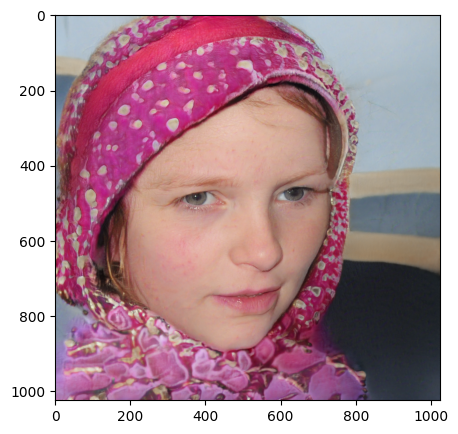

In [9]:
z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
ws = G.mapping(z, label)

generated_tensor = G.synthesis(ws, noise_mode=noise_mode, force_fp32=True)
plot_image(generated_tensor, (5,5))


## Truncation


truncation - интерполяция в сторону среднего вектора



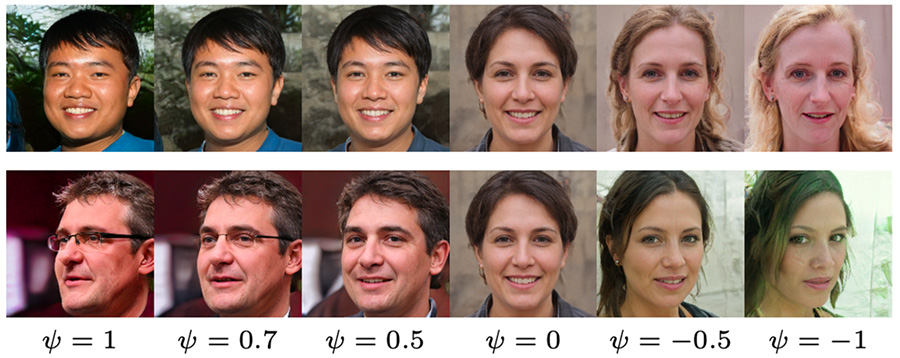

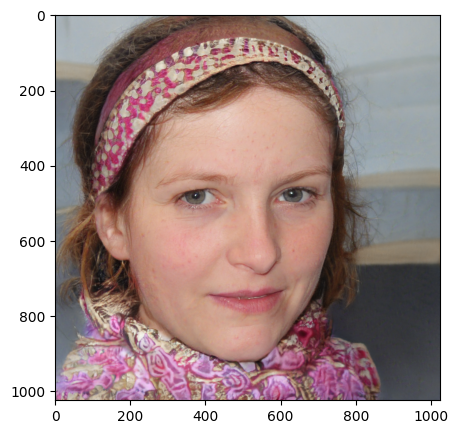

In [10]:
z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
ws = G.mapping(z, label, truncation_psi=(0.7))

generated_tensor = G.synthesis(ws, noise_mode=noise_mode, force_fp32=True)
plot_image(generated_tensor, (5,5))

## Projection of real images

In [ ]:
!python3 projector.py --outdir=out --num-steps=300 --target=/content/aligned_images/LDCaprio/0.jpg --network=pretrained_models/ffhq.pkl

In [ ]:
!rm -r out

Проекция это поиск точки в латентном пространстве которая визуально будет похожа на реальное изображение


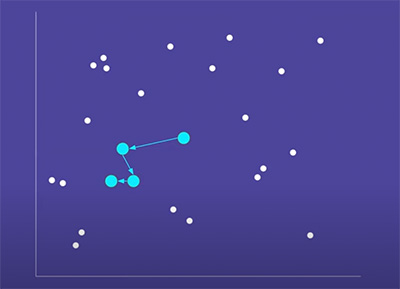

In [22]:
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from tqdm import tqdm
import torch.nn.functional as F



# https://pypi.org/project/pytorch-msssim/
class Rec_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction='mean')

    def forward(self, target, synth):
        target = torch.add(target, 1.0)
        target = torch.mul(target, 127.5)
        target = target / 255

        synth = torch.add(synth, 1.0)
        synth = torch.mul(synth, 127.5)
        synth = synth / 255

        loss = torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss


# https://pypi.org/project/lpips/
class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net='vgg')
        self.lpips_loss.to(device)
        self.lpips_loss.eval()

    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))


# https://github.com/NVlabs/stylegan2-ada-pytorch/blob/main/projector.py#L104
class Reg_loss(nn.Module):
    def __init__(self, noise_bufs):
        super().__init__()
        self.noise_bufs = noise_bufs

    def forward(self,):
        reg_loss = 0.0
        for v in self.noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        return reg_loss

# image = (image - mean) / std
def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor


# загружаем изображение
inv_img_path = "/content/aligned_images/LDCaprio/0.jpg"
target_pil = Image.open(inv_img_path).convert('RGB')
target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)


# инициализируем функции потерь
lpips_loss = Lpips_loss(device)
rec_loss = Rec_loss()

noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
reg_loss = Reg_loss(noise_bufs)

#  loss weights
regularize_noise_weight = 5e5
rec_weight = 0.5
lpips_weoght = 1

# Параметры для оптимизации
num_steps = 150
seed = 42
initial_learning_rate = 0.05
w_avg_samples = 10000

# Получаем средний вектор латентного пространства
z_samples = torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, G.z_dim)).to(device)
w_samples = G.mapping(z_samples, None)
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
w_avg = np.mean(w_samples, axis=0, keepdims=True)   # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

# w or w_plus
w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=False) # pylint: disable=not-callable
w_opt = broadcast_w_sg(w_opt).requires_grad_(True)

# w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable

optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)
generated_tensors = []
for step in tqdm(range(num_steps)):
  synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const')

  lpips_value = lpips_loss(synth_tensor, target_tensor)
  rec_value = rec_loss(synth_tensor, target_tensor)
  reg_value = reg_loss()

  loss = lpips_value*lpips_weoght + rec_value*rec_weight + reg_value*regularize_noise_weight

  optimizer.step()
  optimizer.zero_grad(set_to_none=True)
  loss.backward()

  generated_tensors.append(synth_tensor)
generated_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const', force_fp32=True)

# save_image(generated_tensor, path="./projected_image.png")
print(loss.item())

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 120MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


114595.578125


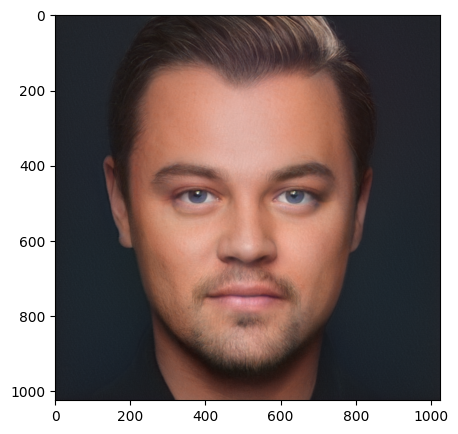

In [ ]:
plot_image(generated_tensor, plot_size=(5,5))

In [ ]:
import imageio

def save_video(video_path):
  video = imageio.get_writer(video_path, mode='I', fps=10, codec='libx264', bitrate='16M')
  target_uint8 = np.array(target_pil, dtype=np.uint8)
  print (f'Saving optimization progress video {video_path}')
  for synth_image in generated_tensors:
      synth_image = (synth_image + 1) * (255/2)
      synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
      video.append_data(np.concatenate([target_uint8, synth_image], axis=1))
  video.close()

video_path = "/content/proj_video.mp4"
save_video(video_path)

Saving optimization progress video /content/proj_video.mp4


### Encoder for editing

https://arxiv.org/pdf/2102.02766.pdf

Ld-reg - позволяет дельтам не расходиться

Ladv - Дискриминатор сравнивает латенты

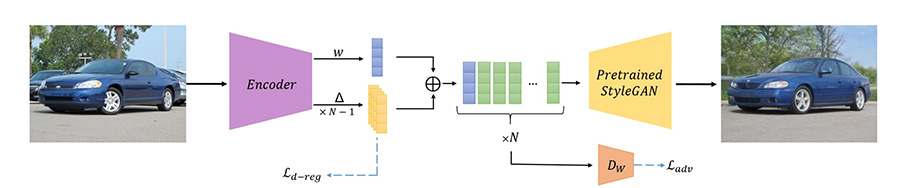

In [11]:
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms

e4e_model, _ = load_e4e_standalone("/content/stylegan2-ada-pytorch/pretrained_models/e4e_ffhq_encode.pt")

image2e4etensor = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


In [16]:
image_path = "/content/aligned_images/LDCaprio/0.jpg"
target_pil = Image.open(image_path).convert('RGB')
target_uint8 = np.array(target_pil, dtype=np.uint8)

e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
initial_latent_vector = e4e_model(e4e_tensor)
print(initial_latent_vector.size())

torch.Size([1, 18, 512])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


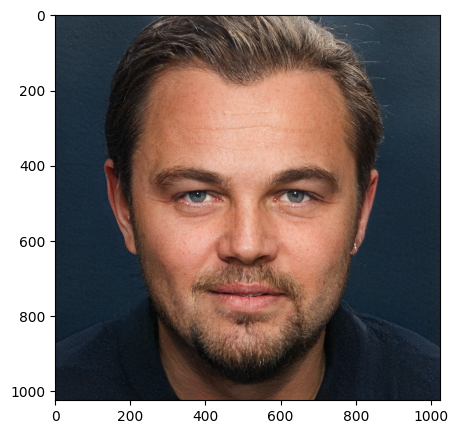

In [17]:
generated_tensor = G.synthesis(initial_latent_vector, noise_mode='const', force_fp32=True)
plot_image(generated_tensor, (5,5))

In [ ]:
import torch.nn as nn
from tqdm import tqdm


num_steps = 100
learning_rate = 0.01
initial_latent_vector = nn.Parameter(initial_latent_vector, requires_grad=True)

optimizer = torch.optim.Adam([initial_latent_vector], lr=learning_rate)
generated_tensors = []
for step in tqdm(range(num_steps)):
  synth_tensor = G.synthesis(initial_latent_vector, noise_mode='const')

  lpips_value = lpips_loss(synth_tensor, target_tensor)
  rec_value = rec_loss(synth_tensor, target_tensor)
  reg_value = reg_loss()

  loss = lpips_value*lpips_weoght + rec_value*rec_weight + reg_value*regularize_noise_weight

  optimizer.step()
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  generated_tensors.append(synth_tensor)
generated_tensor = G.synthesis(initial_latent_vector, noise_mode='const', force_fp32=True)

# save_image(generated_tensor, path="./projected_image.png")
print(loss.item())

 38%|███▊      | 38/100 [00:22<00:37,  1.64it/s]

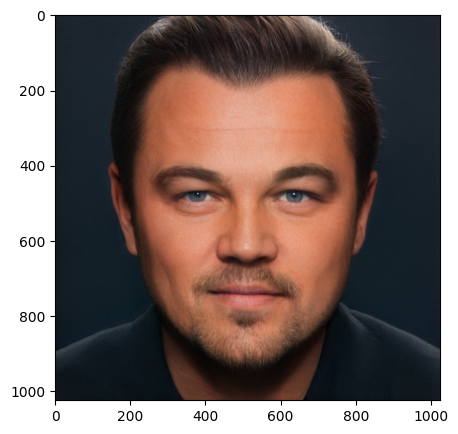

In [ ]:
plot_image(generated_tensor, plot_size=(5,5))

In [ ]:
video_path = "/content/proj_video_e4e.mp4"
save_video(video_path)

## Plot latent using PCA

Метод главных компонент

https://habr.com/ru/post/304214/

In [ ]:
import os
import glob
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



images_path = "/content/aligned_images"
save_path = "/content/e4e_invertion"

data = []
for persone in sorted(os.listdir(images_path)):
    person_images = os.path.join(images_path, persone)
    save_folder = os.path.join(save_path, persone)
    os.makedirs(save_folder, exist_ok=True)

    for image_name in os.listdir(person_images):
      image_path = os.path.join(person_images, image_name)

      target_pil = Image.open(image_path).convert('RGB')
      target_uint8 = np.array(target_pil, dtype=np.uint8)

      e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)

      latent_vector = e4e_model(e4e_tensor).detach().cpu()
      latent_path = os.path.join(save_folder, f"{image_name[:-4]}.pt")

      torch.save(latent_vector, latent_path)
      data.append([persone, image_name, image_path, latent_path])

df = pd.DataFrame(data, columns = ['key', 'image_name', 'image_path', 'latent_path'])

NameError: name 'image2e4etensor' is not defined

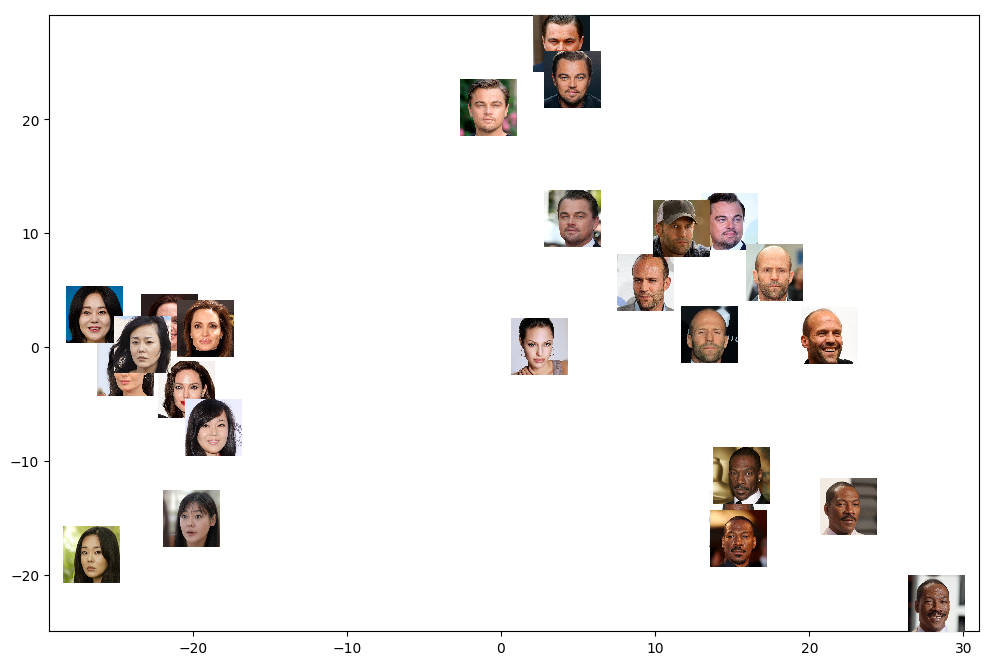

In [ ]:

def getImage(path, zoom=0.04):
    return OffsetImage(plt.imread(path), zoom=zoom)

embedings = []
for index, row in df.iterrows():
    latent_path = row["latent_path"]
    latent = torch.load(latent_path).numpy().squeeze(0)
    embedings.append(latent)

batch = np.stack(embedings, axis=0)
batch = batch.reshape((25, 9216))
pca = PCA(n_components=2, random_state=22).fit(batch)
x = pca.transform(batch)

fig, ax = plt.subplots(figsize=(12,8))
# for x, y, path in zip(x[:, 0], x[:, 1], df.image_path.values.tolist()):
for x, y, df_iter in zip(x[:, 0], x[:, 1], df.iterrows()):
  i, row = df_iter
  path = row["image_path"]
  label = row["key"]
  ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
  ax.add_artist(ab)
  plt.scatter(x,y, label=label)

# plt.legend()
plt.show()




## Interpolation and editing

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
%rm -rf /content/e4e_invertion

In [ ]:
! mv /content/stylegan2-ada-pytorch/editing /content


In [ ]:
from IPython.display import display, FileLink
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torch


def interpolate(latent1, latent2, psi=0.5, indeces=[i for i in range(0,18)]):
    init_latent = latent1.clone()
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)

    edited_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
    init_tensor = G.synthesis(init_latent, noise_mode='const', force_fp32=True)
    plot_image(torch.cat((init_tensor, edited_tensor ), dim=3), (10,10))




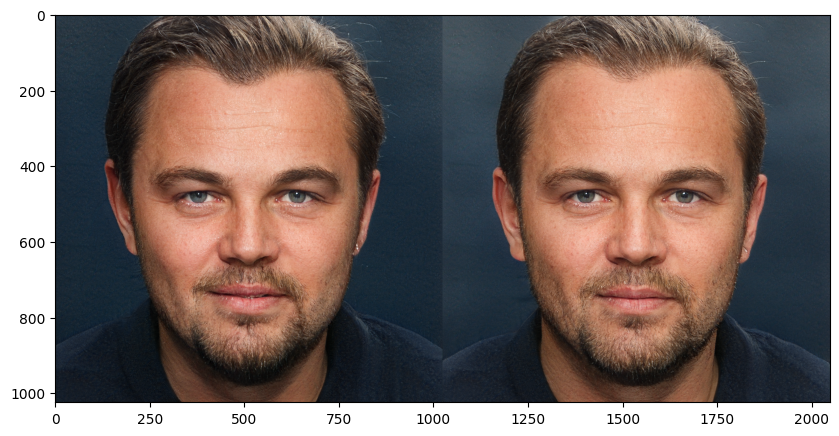

In [ ]:
latent1=torch.load("/content/e4e_invertion/LDCaprio/0.pt").to(device)
latent2=torch.load("/content/e4e_invertion/Stethem/4.pt").to(device)

interpolate(latent1, latent2, psi=0.8)

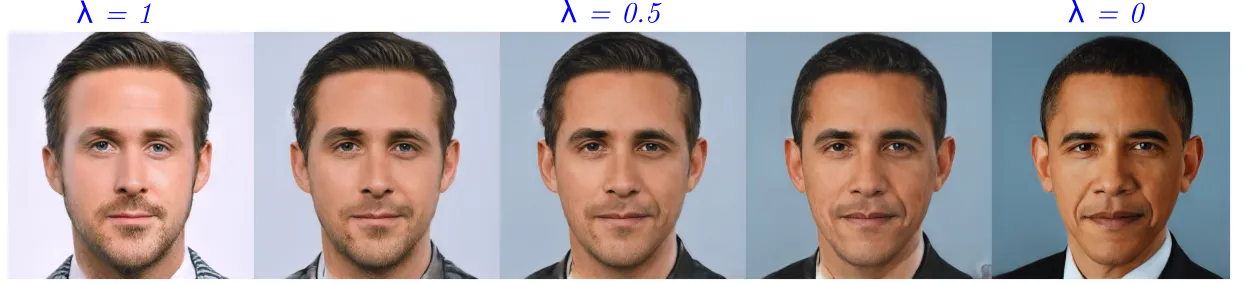

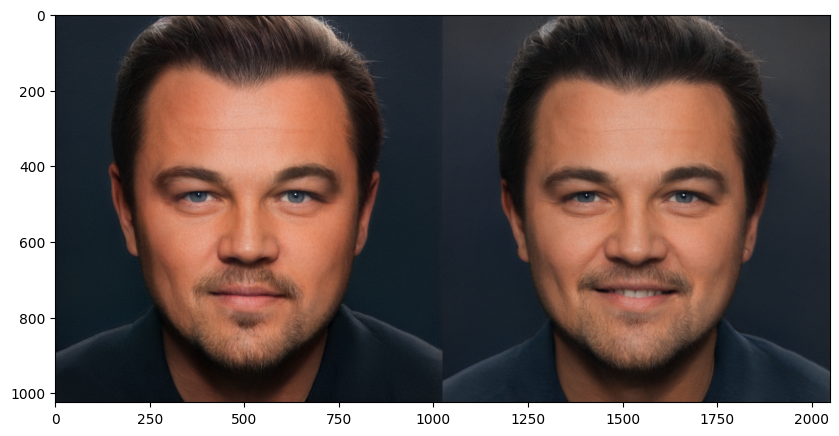

In [ ]:

# latent1=torch.load("/content/e4e_invertion/LDCaprio/0.pt").to(device)
latent1 = initial_latent_vector

# latent2=torch.load("/content/editing/age.pt").to(device)
# latent2=torch.load("/content/editing/pose.pt").to(device)
latent2=torch.load("/content/editing/smile.pt").to(device) # 0.5, 1.5 indeces = [0,1,2,3,4,5,6]
latent2 = broadcast_w_sg(latent2)


# interactive(interpolate, latent1=fixed(latent1), latent2=fixed(latent2),
#             psi=widgets.FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.1))


indeces = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
interpolate(latent1, latent2, psi=0.6, indeces=indeces)

# Homework

In [ ]:
file_id = '1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ms1mv3_arcface_r50_fp16.pth')


In [ ]:
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from stylegan2_models.arcface_model import get_model
import torch.nn.functional as F
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms


def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor



class Arcface_Loss(nn.Module):
    def __init__(self, weights_path, device):
        super().__init__()

        self.arcnet = get_model("r50", fp16=False)
        self.arcnet.load_state_dict(torch.load(weights_path))
        self.arcnet.eval()
        self.arcnet.to(device)

        self.cosin_loss = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, source, synth):

        source = F.interpolate(source,size=(112,112), mode='bicubic')
        synth = F.interpolate(synth,size=(112,112), mode='bicubic')

        emb1 = self.arcnet(source)
        emb2 = self.arcnet(synth)
        loss = (1 - self.cosin_loss(emb1, emb2))[0]
        return loss

# https://drive.google.com/file/d/1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5/view?usp=sharing ссылка на загрузку весов
arcface_path = "/content/stylegan2-ada-pytorch/ms1mv3_arcface_r50_fp16.pth"
attr_path  = "/content/aligned_images/Stethem/0.jpg"
id_path = "/content/aligned_images/AJoly/0.jpg"


"""
  1 Взять 6 фотографии, наборе должны быть хотя бы 2 фото с разным поворотом головы
   - Делаем style transfer
   - Замена лиц с новым Arcface лоссом

  2. Expression Transfer


   # * заменить на полный кадр
  # https://github.com/zllrunning/face-parsing.PyTorch
"""


# .

In [ ]:
ninja
cmake
dlib
imageio-ffmpeg
lpips
pytorch_msssim
torch
pickle
scikit-learn
pandas
opencv-python
Pillow
matplotlib
